## Comparaison des distances sur des simulations de modèles de ressorts perturbés

Chaque jeu de simulation a été simulé pour des paramètres `(F, k)` fixés. Le bruit et les conditions intiales sont aléatoires et varient selon chaque simulation.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
from tqdm import tqdm
import pickle
from sklearn import preprocessing

from descriptor import compute_descriptor
from wasserstein_distance import compute_wasserstein_distance
from kolmogorov_distance import compute_kolmogorov_dist
from data_functions import load_data, plot_data
import simu_ressort

In [2]:
weights = [0., 0.0425034, 0.02624669, 0.30339451, 0.16850823, 0.23280556, 0.14751689, 0.07902472]
names_desc = ['mean', 'std', 'fr_max', 'ampl_max', 'spectral centroid',
              'spectral width', 'spectral platitude', 'spectral asymetry']

# Check que la somme fait bien 1
print(np.sum(weights))

1.0


### Load data

In [3]:
all_simus = simu_ressort.load_obj("./data/ressort/simus.pkl")

print("{} parameters tested, and {} simus for each parameter.".format(len(all_simus),
                                                                      all_simus[0]['N']))
print("The duration of each simu is {} dt.".format(np.shape(all_simus[0]['simu'])[1]))

81 parameters tested, and 200 simus for each parameter.
The duration of each simu is 1000 dt.


`all_simu` contient les simulations, chaque élément contient les paramètres et toutes les simulations effectuées avec ces paramètres dans l'item `simu`

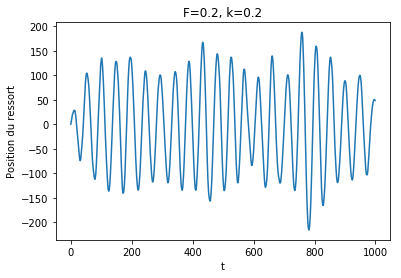

In [4]:
# Exemple
i, j = 10, 10
simu_ressort.plot_ressort(all_simus[i]['simu'][j, :], F=all_simus[i]['F'], k=all_simus[i]['k'])

#### Mettre sous la forme DataFrame comme les simus de poumons
Format qu'il faudrait que l'on change parce qu'il est pas ouf mais bon...

In [61]:
sets = simu_ressort.transform_simus_to_df(all_simus, nmax=200)

100%|█████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 272.81it/s]


In [6]:
def plot_df(df, nmax=None, long=None):
    if not nmax:
        nmax = df.shape[1]
    if not long:
        long = df.shape[0]
    for col in df.columns[:nmax]:
        df[col].plot()
    plt.show()

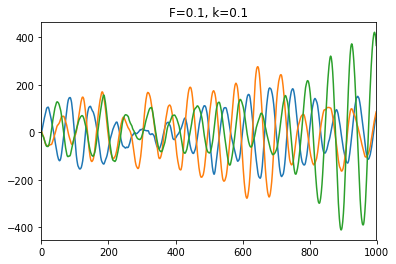

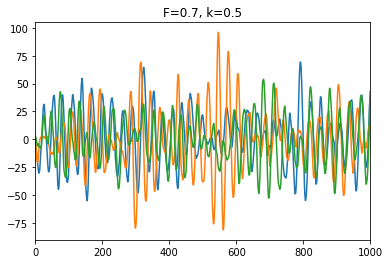

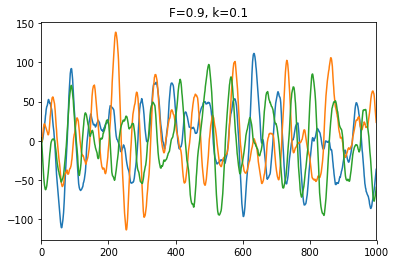

In [7]:
# Exemples de simus
nmax = 3
long = 500

i = 0
plt.title("F={}, k={}".format(all_simus[i]['F'],all_simus[0]['k']))
plot_df(sets[i], nmax, long)

i = 42
plt.title("F={}, k={}".format(all_simus[i]['F'], all_simus[i]['k']))
plot_df(sets[i], nmax, long)

i = 8
plt.title("F={}, k={}".format(all_simus[i]['F'], all_simus[i]['k']))
plot_df(sets[i], nmax, long)

In [8]:
df1 = sets[0]
df1.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99
0,-2.082057,4.903922,0.392982,-4.177039,-1.991302,4.959897,3.771220,1.795757,-4.918775,1.200073,...,-3.454244,-3.856920,-0.850641,-1.722487,2.557496,-4.858952,2.411054,3.975570,3.150832,-0.165346
1,4.665841,1.746565,-4.424868,0.102252,-1.115047,1.780368,-2.283136,1.924358,1.771208,0.616161,...,3.590342,3.566030,3.056669,2.579221,-2.415223,4.289650,-4.878837,-0.064287,-4.303487,3.399428
2,10.910970,-2.395345,-9.344065,3.014926,-0.707682,-1.713152,-6.736470,1.800499,7.905053,-0.621587,...,10.166804,10.591355,9.404567,5.630137,-6.812076,13.201314,-11.530695,-4.589986,-10.902560,5.067176
3,18.073748,-6.644475,-12.316319,4.673165,0.837898,-5.803366,-11.585718,2.727485,15.157794,-2.148096,...,17.547003,18.216695,15.627600,7.603835,-9.648568,22.588399,-18.598923,-6.654841,-16.691872,8.822427
4,24.500137,-11.379377,-14.657089,6.418478,1.314912,-9.185520,-15.426264,6.872483,22.867371,-3.488517,...,25.436620,25.871303,21.307028,10.885727,-10.764236,33.408620,-24.720778,-9.305964,-24.123044,13.311142


In [9]:
compute_kolmogorov_dist(sets[0], sets[42]), compute_kolmogorov_dist(sets[41], sets[42])

D:\Cours\Ponts\MVA\ACTERREA\Code\acterrea\descriptor.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sm = np.sum(fft*(freq**i))/np.sum(fft)
D:\Cours\Ponts\MVA\ACTERREA\Code\acterrea\descriptor.py:41: RuntimeWarning: invalid value encountered in true_divide
  autocorr = np.correlate(y, y)/norm


(0.99999695184988369, 0.70592858807409875)

In [10]:
start_time = time.time()
d = compute_wasserstein_distance(sets[0], sets[42])
print("Execution time: {} min".format(round((time.time() - start_time) / 60, 2)))
print("Distance:", d)

Execution time: 0.31 min
Distance: 78236.4414967


In [11]:
start_time = time.time()
d = compute_wasserstein_distance(sets[0], sets[32])
print("Execution time: {} min".format(round((time.time() - start_time) / 60, 2)))
print("Distance:", d)

Execution time: 0.31 min
Distance: 74894.6324972


## Calcul avec des poids

In [12]:
compute_kolmogorov_dist(sets[0], sets[42], weights), compute_kolmogorov_dist(sets[41], sets[42], weights)

D:\Cours\Ponts\MVA\ACTERREA\Code\acterrea\descriptor.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sm = np.sum(fft*(freq**i))/np.sum(fft)
D:\Cours\Ponts\MVA\ACTERREA\Code\acterrea\descriptor.py:41: RuntimeWarning: invalid value encountered in true_divide
  autocorr = np.correlate(y, y)/norm


(0.99999959595736732, 0.9820188110833673)

In [13]:
start_time = time.time()
d = compute_wasserstein_distance(sets[0], sets[42], weights=weights)
print("Execution time: {} min".format(round((time.time() - start_time) / 60, 2)))
print("Distance:", d)

D:\Cours\Ponts\MVA\ACTERREA\Code\acterrea\descriptor.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sm = np.sum(fft*(freq**i))/np.sum(fft)
D:\Cours\Ponts\MVA\ACTERREA\Code\acterrea\descriptor.py:41: RuntimeWarning: invalid value encountered in true_divide
  autocorr = np.correlate(y, y)/norm


Execution time: 0.29 min
Distance: 23736.474447


In [14]:
start_time = time.time()
d = compute_wasserstein_distance(sets[0], sets[32], weights=weights)
print("Execution time: {} min".format(round((time.time() - start_time) / 60, 2)))
print("Distance:", d)

D:\Cours\Ponts\MVA\ACTERREA\Code\acterrea\descriptor.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sm = np.sum(fft*(freq**i))/np.sum(fft)
D:\Cours\Ponts\MVA\ACTERREA\Code\acterrea\descriptor.py:41: RuntimeWarning: invalid value encountered in true_divide
  autocorr = np.correlate(y, y)/norm


Execution time: 0.27 min
Distance: 22722.5900383


### Calculer les distances entre chaque couple de simus

In [64]:
def compute_dist_sets(sets, weights):
    distances = []
    
    for df1 in tqdm(sets):
    #for df1 in [sets[42]]:
        for df2 in tqdm(sets):
            kolm_dist = compute_kolmogorov_dist(df1, df2, weights=weights)
            wasser_dist = compute_wasserstein_distance(df1, df2, weights=weights)
            distances.append([kolm_dist, wasser_dist])
            
    return np.array(distances)

def plot_comparaison(distances):
    plt.scatter(distances[:, 0], distances[:, 1], marker='x')
    plt.xlabel("Kolmogorov distance")
    plt.ylabel("Wasserstein distance")
    plt.title("Comparaison des distances")
    plt.show()

**Selectionner que qq jeux de param sinon trop long**

In [65]:
# Sets = liste de dataFrames


def transform_to_df(data, nmax=None):
    df = pd.DataFrame(data)
    df.columns = ['V' + str(i) for i in range(data.shape[1])]
    df = df[['V' + str(i) for i in range(nmax)]]
    return df

sets = []

for i in range(len(all_simus)):
    sets.append({
        'data': transform_to_df(all_simus[i]['simu'].T, nmax=100),
        'F': all_simus[i]['F'],
        'k': all_simus[i]['k']
    })
    
list_k = [0.2, 0.5, 0.8]
list_F = [0.2, 0.5, 0.8]

sets_to_compute_dist = []
for set_ in sets:
    if set_['F'] in list_F and set_['k'] in list_k:
        sets_to_compute_dist.append(set_['data'])
        
print(len(sets_to_compute_dist))

9


In [ ]:
distances = compute_dist_sets(sets_to_compute_dist, weights)

simu_ressort.save_obj(distances, './data/distances_ressort_9.pkl')

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]D:\Cours\Ponts\MVA\ACTERREA\Code\acterrea\descriptor.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sm = np.sum(fft*(freq**i))/np.sum(fft)
D:\Cours\Ponts\MVA\ACTERREA\Code\acterrea\descriptor.py:41: RuntimeWarning: invalid value encountered in true_divide
  autocorr = np.correlate(y, y)/norm

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [02:43<00:20, 20.46s/it]


 11%|█████████▎                                                                          | 1/9 [00:23<03:08, 23.53s/it]

In [ ]:
plot_comparaison(distances)

In [ ]:
distances

In [ ]:
plt.scatter(distances[:20, 0], distances[:20, 1], marker='x')
plt.show()